# Creación de instancias simuladas en Ecuador para el IVRP

<div class="alert alert-block alert-info">
Este cuadernillo está hecho simular instancias del IVRP para probar el modelo entero y técnicas de solución.
</div>

In [1]:
# Gurobi
from gurobipy import *

In [2]:
# Packages
import numpy  as np
import pandas as pd
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Información georeferencial
import igraph    as ig
import osmnx     as ox
import networkx  as nx
import geopandas as gp
from connect_poi      import connect_poi
from shapely.geometry import Point, LineString

# Imprimir en notación decimal
np.set_printoptions(suppress=True)#np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Manipulación de fechas
import datetime
import locale
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

In [3]:
# Aliases
array, app, arange, zeros, unique, asarray = np.array, np.append, np.arange, np.zeros, np.unique, np.asarray
mean, take_along_axis, default_rng = np.mean, np.take_along_axis, np.random.default_rng
where, column_stack, hstack = np.where, np.column_stack, np.hstack
nan, isnan, ntn, c_, suma = np.nan, np.isnan, np.nan_to_num, np.c_, np.sum
DataFrame, concat = pd.DataFrame, pd.concat

<div class="alert alert-block alert-warning">
Ingresamos una dirección, donde proyectaremos los puntos de interés (POIs). 
    
<b>Nota:</b> Para usar este cuadernillo es importante que la dirección coincida con la dirección de la base creada con `Points of Interest`.
</div>

In [4]:
dirección = 'La Carolina, Quito, Ecuador'

Cargamos el archivo preprocesado de los puntos de interés:

In [5]:
POIs = gp.read_file('poi.gpkg');    POIs.osmid = POIs.osmid.astype('int64', copy=False)

In [6]:
POIs.head()

,osmid,amenity,name,lon,lat,geometry
0,346384464,restaurant,Oh Qué Bueno Más,-78.477771,-0.178577,POINT (-78.47777 -0.17858)
1,346384882,bank,Citi Ecuador,-78.479203,-0.177675,POINT (-78.47920 -0.17767)
2,348028951,cinema,Multicines,-78.484794,-0.176749,POINT (-78.48479 -0.17675)
3,348029163,cinema,Cinemark,-78.492821,-0.174870,POINT (-78.49282 -0.17487)
4,348042041,arts_centre,Centro Artístico Don Bosco,-78.492447,-0.187668,POINT (-78.49245 -0.18767)


Elegimos una muestra para el IVPR:

In [29]:
rng = default_rng(1993)
η   = 8

In [30]:
Choice = rng.choice(POIs.index.size, η, replace=False, shuffle=False)

Obtenemos el siguiente objeto:

In [31]:
poi = POIs.iloc[Choice]

In [32]:
poi.describe()

,osmid,lon,lat
count,8.000000e+00,8.000000,8.000000
mean,3.892240e+09,-78.482637,-0.181799
std,1.668632e+09,0.003177,0.004738
min,4.060321e+08,-78.487820,-0.188020
25%,3.900790e+09,-78.483809,-0.185031
50%,4.256344e+09,-78.481577,-0.181761
75%,4.335109e+09,-78.480473,-0.178413
max,6.232873e+09,-78.479640,-0.174870


In [51]:
poi

,osmid,amenity,name,lon,lat,geometry
155,4258780091,restaurant,Bela,-78.480658,-0.183142,POINT (-78.48066 -0.18314)
312,6232873120,fast_food,Enchurrados,-78.479919,-0.178707,POINT (-78.47992 -0.17871)
41,2943603334,restaurant,La Parilla de Homero,-78.479640,-0.177529,POINT (-78.47964 -0.17753)
87,4219851992,restaurant,Big S,-78.487244,-0.184191,POINT (-78.48724 -0.18419)
232,4564095890,fast_food,Village,-78.481708,-0.188020,POINT (-78.48171 -0.18802)
127,4254824136,restaurant,Freshi,-78.482664,-0.187549,POINT (-78.48266 -0.18755)
7,406032130,fuel,Primax Mundo Tuerca,-78.487820,-0.174870,POINT (-78.48782 -0.17487)
150,4257862931,restaurant,Campo Viejo,-78.481446,-0.180380,POINT (-78.48145 -0.18038)


## Rutas pedestres

<div class="alert alert-block alert-warning">
Obtenemos la red a partir de una distancia fija desde la dirección especificada. Intentamos que la red sea lo más completa para poder conectar la mayor cantidad de puntos usando la mayor cantidad de calles.
</div>

In [17]:
GG, ρ = ox.graph_from_address(dirección, distance=1100, simplify=False, #network_type='walk', 
                              truncate_by_edge=True, clean_periphery=False, return_coords=True)
GG    = ox.get_undirected(GG)

Mostramos la red y los puntos de interés que todavía no han sido proyectados.

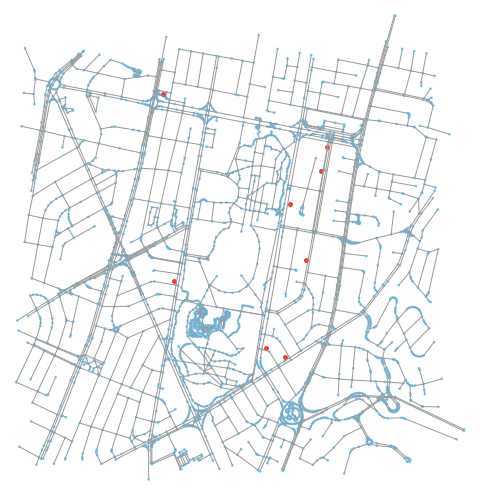

La conexidad es garantizada pues la red es de caminata.


In [18]:
fig, ax = ox.plot_graph(GG, fig_height=7, fig_width=10, show=False, close=False,
                       node_size = 7, ) # Incrementar para + resolución
for a in zip(poi.lon, poi.lat):    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.75)
plt.tight_layout()
plt.show()
print('La conexidad es garantizada pues la red es de caminata.' if nx.is_connected(GG) else 'Falso')

In [19]:
# Proyectamos el ingreso a las estructuras desde las calles del mapa
poi['key']   = poi.osmid
nodes, edges = ox.graph_to_gdfs(GG)
new_nodes, new_edges = connect_poi(poi, nodes, edges, key_col='key', path=None, threshold=200, knn=5)

Construyendo rtree...
Actualizando nodos externos...
Proyectando POIs a la red...
Actualizando nodos internos...
Actualizando aristas internas...
Actualizando enlaces externos...
Eliminando proyecciones fallidas: 0/8 (0.00%)
** Nota **: duplicación en llaves de coordenadas para los nodos
Número de nodos: 3725
Número de llaves de coordenadas: 3724
Nodos 'from' perdidos: 0
Nodos 'to' perdidos:   0


In [20]:
# Corregimos las entradas de los nuevos DataFrames donde la función ha dejado ambigüedad
new_nodes.gdf_name = nodes.gdf_name
# La función crea nuevos campos en el pandas que no constaban previamente, así que aquí se corrige la información
new_edges['u'] = where(new_edges['from'].notnull(), new_edges['from'], new_edges['u']).astype('int64',copy=False)
new_edges['v'] = where(new_edges['to'].notnull(),   new_edges['to'],   new_edges['v']).astype('int64',copy=False)
new_edges['oneway'] = where(new_edges['to'].notnull(), True,   new_edges.oneway)

new_edges.drop('from', axis=1, inplace=True)
new_edges.drop('to',   axis=1, inplace=True)
new_edges.key   = 0
new_nodes.osmid = new_nodes.osmid.astype('int64', copy=False)
new_nodes.index = new_nodes.index.astype('int64', copy = False)
new_nodes.replace('projected_pap', np.NaN, inplace=True)
new_edges.replace('projected_footway', 'footway', inplace=True)

In [21]:
G = ox.get_undirected(ox.gdfs_to_graph(new_nodes, new_edges))
print('La conexidad sigue siendo garantizada.' if nx.is_connected(G) else '¡Grafo no conexo!')

La conexidad sigue siendo garantizada.


Para calcular la red de caminos más cortos, es preferible utilizar el paquete `iGraph`, el cual contiene una serie de rutinas optimizadas en `C` para el cálculo sobre grafos.

In [22]:
G = nx.relabel.convert_node_labels_to_integers(G)

In [23]:
# Grafo de networkx a grafo en igraph
G_ig = ig.Graph(directed=False)
G_ig.add_vertices(list(G.nodes()))
G_ig.add_edges(list(G.edges()))
G_ig.vs['osmid'] = list(nx.get_node_attributes(G, 'osmid').values())
G_ig.es['length']  = list(nx.get_edge_attributes(G, 'length').values())

In [24]:
#Δ = [v['name'] for v in G_ig.vs() if v['osmid'] in poi.osmid.values]            # por construcción coinciden
Δ = {v['osmid']: v['name'] for v in G_ig.vs() if v['osmid'] in poi.osmid.values }
Δ = [Δ[v] for v in poi.osmid.values]

In [25]:
d_pedestre = DataFrame(G_ig.shortest_paths_dijkstra(source=Δ, target=Δ, weights='length'))

Para la velocidad de caminata, usamos la media de caminata para personas entre 30 a 49 años según [este estudio](https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age).

In [26]:
media_p     = (1.43+1.39)/2                        # Segundos
media_p    *= 60.0                                 # Minutos
t_pedestre  = (1/media_p)*d_pedestre
t_pedestre  = t_pedestre.round(2)

In [27]:
t_pedestre.head()

,0,1,2,3,4,5,6,7
0,0.00,6.22,7.71,12.92,8.05,7.90,20.46,5.67
1,6.22,0.00,1.78,17.13,14.01,13.87,14.93,4.77
2,7.71,1.78,0.00,18.63,15.51,15.37,13.25,6.26
3,12.92,17.13,18.63,0.00,11.66,10.22,15.41,14.49
4,8.05,14.01,15.51,11.66,0.00,2.39,25.49,11.67


Finalmente, procedemos a guardar los valores de tiempo.

In [28]:
t_pedestre.to_csv('Instances/Pollster_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

## Rutas vehiculares

<div class="alert alert-block alert-warning">
Obtenemos la red a partir de una distancia fija desde la dirección especificada. Intentamos que la red sea lo más completa para poder conectar la mayor cantidad de puntos usando la mayor cantidad de calles.
</div>

In [33]:
GG, ρ = ox.graph_from_address(dirección, distance=1300, simplify=False, network_type='drive', retain_all=True,
                              truncate_by_edge=True, clean_periphery=True, return_coords=True)

Mostramos la red y los puntos de interés que todavía no han sido proyectados.

In [34]:
INEC = DataFrame({'osmid':[99], 'amenity':['center'], 'name':['INEC'], 'lon':[ρ[1]], 'lat':[ρ[0]], 'geometry':[Point(ρ[1],ρ[0])]})

In [35]:
#poi = pd.concat([INEC, poi], ignore_index=True)
poiv = gp.GeoDataFrame(pd.concat([INEC, poi], ignore_index=True))
poiv.crs = poi.crs

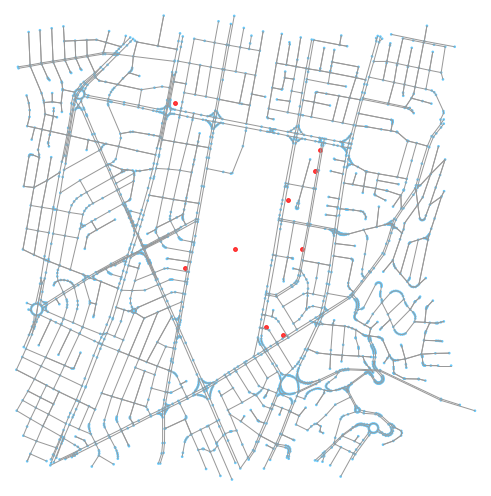

In [36]:
fig, ax = ox.plot_graph(GG, fig_height=7, fig_width=10, show=False, close=False,
                       node_size = 7, ) # Incrementar para + resolución
for a in zip(poiv.lon, poiv.lat):    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.75)
plt.tight_layout()
plt.show()

In [37]:
# Proyectamos el ingreso a las estructuras desde las calles del mapa
poiv['key']   = poiv.osmid
nodes, edges  = ox.graph_to_gdfs(GG)
new_nodes, new_edges = connect_poi(poiv, nodes, edges, key_col='key', path=None, threshold=400, knn=5)

Construyendo rtree...
Actualizando nodos externos...
Proyectando POIs a la red...
Actualizando nodos internos...
Actualizando aristas internas...
Actualizando enlaces externos...
Eliminando proyecciones fallidas: 0/9 (0.00%)
Nodos 'from' perdidos: 0
Nodos 'to' perdidos:   0


In [38]:
# Corregimos las entradas de los nuevos DataFrames donde la función ha dejado ambigüedad
new_nodes.gdf_name = nodes.gdf_name
# La función crea nuevos campos en el pandas que no constaban previamente, así que aquí se corrige la información
new_edges['u'] = where(new_edges['from'].notnull(), new_edges['from'], new_edges['u']).astype('int64',copy=False)
new_edges['v'] = where(new_edges['to'].notnull(),   new_edges['to'],   new_edges['v']).astype('int64',copy=False)
#new_edges['oneway'] = where(new_edges['to'].notnull(), True,   new_edges.oneway)
new_edges['lanes']    = where(new_edges.highway =='projected_footway', '2', new_edges.lanes)
new_edges['maxspeed'] = where(new_edges.highway =='projected_footway', '50', new_edges.maxspeed)

new_edges.drop('from', axis=1, inplace=True)
new_edges.drop('to',   axis=1, inplace=True)
new_edges.key   = 0
new_nodes.osmid = new_nodes.osmid.astype('int64', copy=False)
new_nodes.index = new_nodes.index.astype('int64', copy = False)
new_nodes.replace('projected_pap', np.NaN, inplace=True)
new_nodes.replace('poi', np.NaN, inplace=True)
new_edges.replace('projected_footway', 'residential', inplace=True)

El grafo resultante no tendría arcos de regreso, por lo cual los añadimos:

In [39]:
# Arcos de regreso
ct = list(new_edges.columns.values)
ct[0], ct[1] = ct[1], ct[0]
below = new_edges[new_edges.u.isin(poiv.osmid)].copy().reindex(columns=ct, copy=False)
below.columns.values[[0, 1]] = ['u', 'v']
below.osmid = below.osmid.apply(lambda x: x[::-1])
below.geometry = below.geometry.apply(lambda x: LineString(x.coords[::-1]) )

In [40]:
G = ox.gdfs_to_graph(new_nodes, new_edges.append(below, ignore_index=True))

Para calcular la red de caminos más cortos, es preferible utilizar el paquete `iGraph`, el cual contiene una serie de rutinas optimizadas en `C` para el cálculo sobre grafos.

In [41]:
G = nx.relabel.convert_node_labels_to_integers(G)

In [42]:
# Grafo de networkx a grafo en igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(list(G.nodes()))
G_ig.add_edges(list(G.edges()))
G_ig.vs['osmid'] = list(nx.get_node_attributes(G, 'osmid').values())
G_ig.es['length']  = list(nx.get_edge_attributes(G, 'length').values())

In [43]:
#Δ = [v['name'] for v in G_ig.vs() if v['osmid'] in poiv.osmid.values]            # por construcción coinciden
Δ = {v['osmid']: v['name'] for v in G_ig.vs() if v['osmid'] in poiv.osmid.values }
Δ = [Δ[v] for v in poiv.osmid.values]

In [44]:
d_vehicular = DataFrame(G_ig.shortest_paths_dijkstra(source=Δ, target=Δ, weights='length'))

Para la velocidad vehicular, usamos $30$ kilómetros por hora.

In [45]:
media_v    = 30 * 1000/60                         # Minutos
t_vehicular = (1/media_v)*d_vehicular
t_vehicular = t_vehicular.round(2)

In [46]:
t_vehicular.head()

,0,1,2,3,4,5,6,7,8
0,0.00,2.55,2.94,3.43,4.22,1.82,1.50,4.85,2.27
1,1.85,0.00,1.66,2.69,4.13,1.46,1.41,4.11,1.54
2,2.03,1.05,0.00,1.80,4.28,2.47,2.42,3.03,1.32
3,2.29,1.30,0.31,0.00,4.06,2.73,2.67,2.81,1.57
4,4.35,4.84,3.96,3.67,0.00,3.00,2.96,2.80,4.56


In [47]:
# Verificar si no existe un camino entre algún par de nodos.
any(np.isinf(t_vehicular).any())

False

Finalmente, procedemos a guardar los valores de tiempo.

In [48]:
t_vehicular.to_csv('Instances/Vehicle_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

## Servicio

In [11]:
Service = DataFrame(rng.integers(1,20,η+1))
Service.at[0,0] = 0
Service.to_csv('Instances/Service_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

Más información de `OSMnx` puede encontrarse en la documentación en [readthedocs](https://osmnx.readthedocs.io/en/stable/osmnx.html), en este [blog](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) o en su [git](https://github.com/gboeing/osmnx).

También hay [tutoriales](https://github.com/gboeing/osmnx-examples) en [binder](https://mybinder.org/v2/gh/gboeing/osmnx-examples/master).

In [ ]:
#https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/F5UNSK

# Otros

In [71]:
d_pedestre = {a: [nx.shortest_path_length(G, a, b, weight='length') for b in poi.osmid.values] for a in poi.osmid.values}

In [ ]:
DataFrame.from_dict(d_pedestre)

In [ ]:
#nx.convert_node_labels_to_integers(G, label_attribute='old_label').nodes[0]['old_label']

In [57]:
nx.has_path(g, list(G.edges(poi.osmid.values[0]))[0][1], poi.osmid.values[0])

True

In [25]:
P_ρ = ox.geo_utils.get_nearest_node(GG, ρ[::-1])

264941087

In [ ]:
G, ν = ox.graph_from_address('La Carolina, Quito, Ecuador', distance=1000, simplify=True, return_coords=True)
print('Conexidad fuerte?', 'Verdad' if nx.is_strongly_connected(G) else 'Falso')

In [ ]:
ox.graph_from_address(dirección, distance=1100, simplify=True, network_type='walk', truncate_by_edge=True, clean_periphery=False)

In [ ]:
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False,
                       node_size = 7, ) # Incrementar para + resolución
for a in zip(poiv.lon, poiv.lat):    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.75)
plt.tight_layout()
fig.savefig('Map.pdf', bbox_inches='tight')
plt.show()